In [1]:
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../pba-signet/')

import pba.augmentation_transforms_hp as augmentation_transforms_hp
from pba.utils import parse_log_schedule
from pba.data_utils import parse_policy

# Ignore the divided by zero warning in probability calculation
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
# Initialize hp policies.
hp_epochs = 35
train_epochs = 35
multiplier=float(train_epochs)/ hp_epochs
save=True

search_name = 'search_train_5kt6_mag_newprob'
policy_file = 'pbt_policy_00005.txt'

base_policy_names =  [
    'Brightness', 'Color', 'Invert', 'Sharpness', 'Posterize', 
    'Solarize', 'Equalize', 'AutoContrast', 'Cutout', 'Contrast'
]

In [3]:
""" Uncomment the relevant extra policy name """ 

# search-15aug-X
extra_policy_names = ['Blur', 'Smooth', 'EdgeEnhance', 'FlipLR', 'ScaleCrop', 'Rain', 'Snow',  'Fog', 'SpeedBlur']

In [4]:
policy_path = '../results/'+ search_name +'/' + policy_file
hp_policy = (parse_log_schedule(policy_path, hp_epochs, multiplier), 'hp_policy')
policy, dset = hp_policy

save_path = 'graphs/' + search_name
mag_save_name =  os.path.join(save_path, "magnitude")
prob_save_name = os.path.join(save_path, "probability")

if not os.path.exists(save_path) and save:
    os.makedirs(save_path)
    os.makedirs(prob_save_name)
    os.makedirs(mag_save_name)

prob_save_name = os.path.join(prob_save_name, policy_file.rstrip(".txt"))
mag_save_name = os.path.join(mag_save_name, policy_file.rstrip(".txt"))


policy_names = base_policy_names + extra_policy_names
print("Using following policy names: \n{}".format(policy_names))

INFO:tensorflow:final len 35
Using following policy names: 
['Brightness', 'Color', 'Invert', 'Sharpness', 'Posterize', 'Solarize', 'Equalize', 'AutoContrast', 'Cutout', 'Contrast', 'Blur', 'Smooth', 'EdgeEnhance', 'FlipLR', 'ScaleCrop', 'Rain', 'Snow', 'Fog', 'SpeedBlur']


In [5]:
# mention names of operations in order as in augmentation_transforms_hp.py which was used to search for given policy
probability_results = {}
for name in policy_names:
    probability_results[name] = []

magnitude_results = copy.deepcopy(probability_results)
upper_probability  = copy.deepcopy(probability_results)
upper_magnitude = copy.deepcopy(probability_results)
bottom_probability = copy.deepcopy(probability_results)
bottom_magnitude= copy.deepcopy(probability_results)

def parse_policy_hyperparams(policy_hyperparams):
    """We have two sets of hparams for each operation, which we need to split up."""
    split = len(policy_hyperparams) // 2
    policy = parse_policy(policy_hyperparams[:split], augmentation_transforms_hp)
    policy.extend(parse_policy(policy_hyperparams[split:], augmentation_transforms_hp))
    return policy

def mean_hyperparams(policy):
    """Get mean value of two set of hparams in each operation, 
    both magnitude and probability."""
    for one_policy in policy:
        parsed_policy = parse_policy_hyperparams(one_policy)
        
        half_policy = len(parsed_policy) // 2
        # Follow the policy order in augmentation_transforms_hp.py 
        # line 64: name, probability, level = xform
        for i in parsed_policy[:half_policy]:
            upper_probability[i[0]].append(i[1])
            upper_magnitude[i[0]].append(i[2])
    
        for i in parsed_policy[half_policy:]: 
            bottom_probability[i[0]].append(i[1])
            bottom_magnitude[i[0]].append(i[2])

    for key, value in upper_probability.items():
        upper_array = np.array(upper_probability[key])
        bottom_array = np.array(bottom_probability[key])
        tmp_array = np.divide((upper_array+bottom_array),2)
        tmp_array = np.round(tmp_array, decimals=4).tolist()
        probability_results[key]=tmp_array

    for key, value in upper_magnitude.items():
        upper_array = np.array(upper_magnitude[key])
        bottom_array = np.array(bottom_magnitude[key])
        tmp_array = np.divide((upper_array+bottom_array),2)
        tmp_array = np.round(tmp_array, decimals=4).tolist()
        magnitude_results[key]=tmp_array
    return probability_results, magnitude_results

probability_results, magnitude_results = mean_hyperparams(policy)


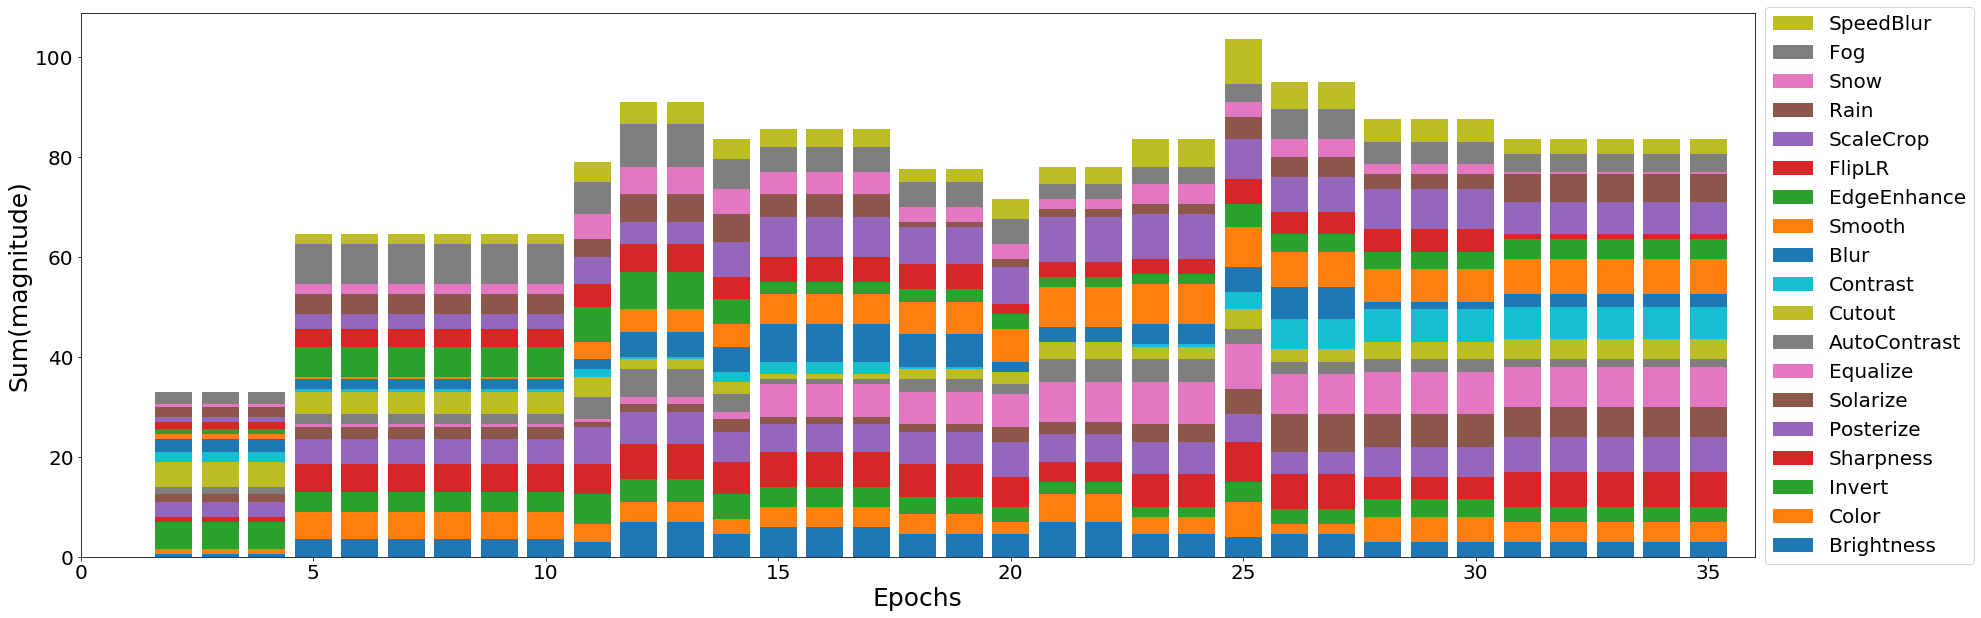

In [6]:
ind_constant = len(magnitude_results["Brightness"])
ind = np.arange(ind_constant) + 1

global bottom
bottom = np.zeros(ind_constant)

def update_bottom(bar_heights):
    global bottom
    old_bottom = copy.copy(bottom)
    bottom += np.array(bar_heights)
    return old_bottom


# Plot bars now
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)

for name in policy_names:
    plt.bar(ind, magnitude_results[name], bottom=update_bottom(magnitude_results[name]), label=name)

fontsize = 20
plt.ylabel('Sum(magnitude)', fontsize=fontsize+5)
plt.xlabel('Epochs', fontsize=fontsize+5)
#plt.title('Magnitudes', fontsize=fontsize+5)
plt.xlim([0, ind_constant+1])

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize)

if save:
    plt.savefig(mag_save_name + "_magnitude.png", bbox_inches='tight')
plt.show()

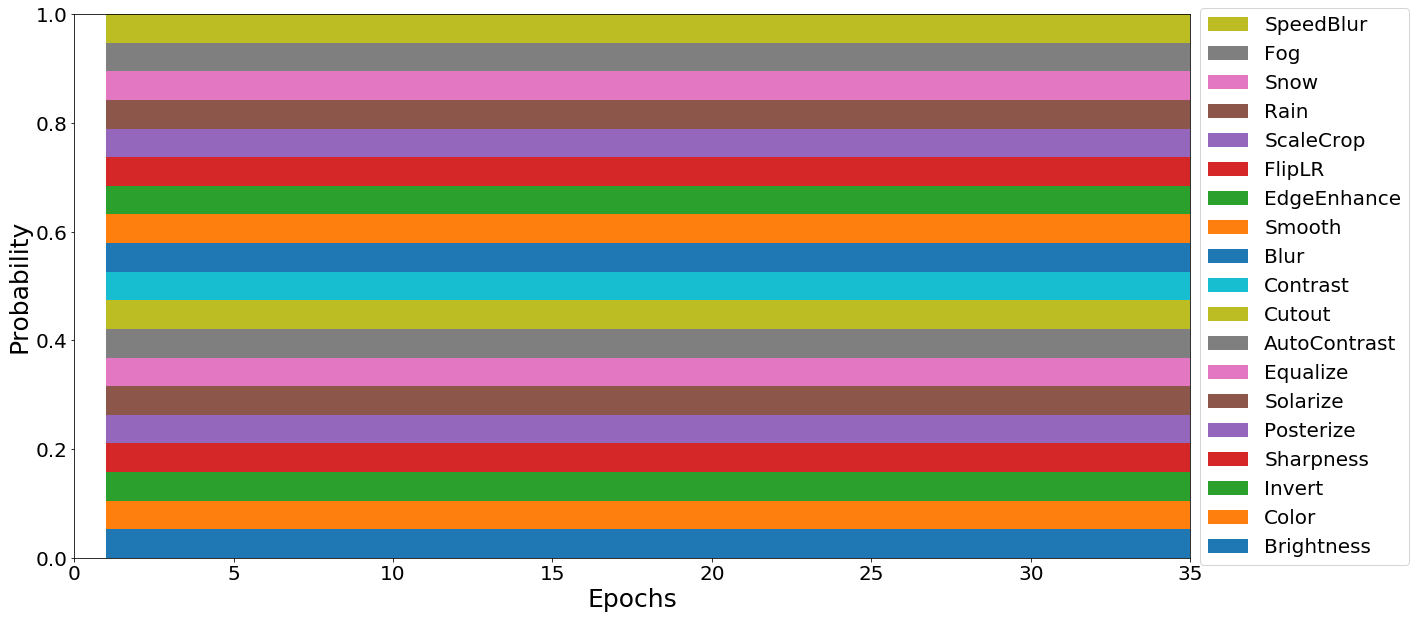

In [7]:
# Get total epochs 
epochs = len(next(iter(probability_results.values())))

# Get sum of each operation magnitude at every epochs. 
# [sum of epoch1, sum of epoch2, sum of epoch3...]
def sum_results_array (index_to_sum, results_dict):
    sums = np.zeros(len(next(iter(results_dict.values()))))
    i = 0
    for value in results_dict.values():
        value = np.array(value)
        sums = sums+value
        if i==index_to_sum:
            break
        i=i+1
    return sums

# Sum of probability. 
sum_results = sum_results_array(epochs, probability_results)

# Get every operation's probability portion in that epoch
bars_to_plot = [np.nan_to_num(np.divide(probability_results[name], sum_results)) for name in policy_names]

# Plot
plt.rcParams["figure.figsize"] = [20,10]
# ind = np.arange(epochs)
plt.stackplot(ind, bars_to_plot, labels=policy_names)

plt.legend(reversed(plt.legend().legendHandles), reversed(policy_names), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize)

plt.xlim([0, epochs])
plt.ylim([0, 1])
plt.ylabel('Probability', fontsize=fontsize+5)
plt.xlabel('Epochs', fontsize=fontsize+5)
#plt.title('Probability', fontsize=fontsize+5)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

if save:
    plt.savefig(prob_save_name + "_probability.png", bbox_inches='tight')
plt.show()